<a href="https://colab.research.google.com/github/DSookarah/CE888/blob/main/Lab_3/bank_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pycomp

In [2]:
# Importing all necessary librairies

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pycomp.viz.insights import *
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Importing bank dataset

data = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv', delimiter = ";")
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [4]:
# Dropping the duration column
data_clean = data.drop(['duration','y'],axis =1)  
# Our target variable is y
target = data['y']                               

In [5]:
data_clean.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
# Checking the features datatypes
data_clean.dtypes         

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object

In [7]:
# Finding out which values are unique for the different columns
object_col = []
for i in data_clean:
  if data_clean[i].dtypes == 'object':
    print(i.upper(),' >>>>',data_clean[i].unique())
    object_col.append(i)

JOB  >>>> ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
MARITAL  >>>> ['married' 'single' 'divorced' 'unknown']
EDUCATION  >>>> ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
DEFAULT  >>>> ['no' 'unknown' 'yes']
HOUSING  >>>> ['no' 'yes' 'unknown']
LOAN  >>>> ['no' 'yes' 'unknown']
CONTACT  >>>> ['telephone' 'cellular']
MONTH  >>>> ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
DAY_OF_WEEK  >>>> ['mon' 'tue' 'wed' 'thu' 'fri']
POUTCOME  >>>> ['nonexistent' 'failure' 'success']


# ONE HOT ENCODING

In [8]:
# Performing one hot encoding
data_clean = pd.get_dummies(data_clean, columns=object_col)  

In [9]:
data_clean.shape                

(41188, 62)

In [10]:
# How many targets we have in the dataset.
# Data imablance check
target.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

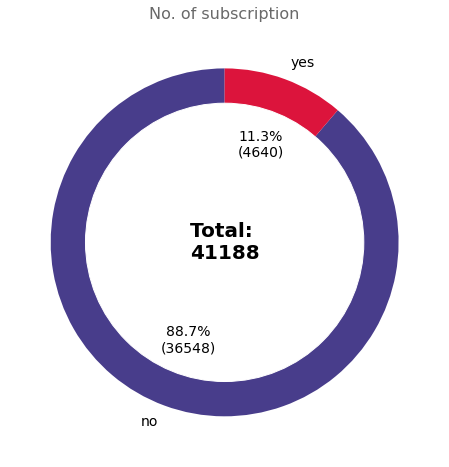

In [12]:
plot_donut_chart(df=data, col='y',title='No. of subscription')

In [13]:
# Preparing training and testing datasets
inputs = data_clean.copy()
min_max_scaler = MinMaxScaler()
input = min_max_scaler.fit_transform(inputs.values.reshape(-1,len(inputs.columns)))
target = target.apply(lambda x: 1 if x=='yes' else 0)

In [14]:
# Function for the random forest classifier
# Metric used is f1 score
def model_RFC(input,target,n_estimators,max_depth,random_state):

  x_train, x_test, y_train, y_test = train_test_split(input,target, test_size=0.2,random_state=50,stratify=target)
  cv = RepeatedStratifiedKFold(n_splits =10, n_repeats=1)         
  RFC = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, random_state = random_state)
  RFC.fit(x_train,y_train)
  cv_RFC = cross_val_score(RFC, x_train, y_train, cv=cv,scoring='f1')
  print('F1 score -->', cv_RFC.mean())
  return RFC, cv_RFC, x_train, y_train

In [15]:
RFC, cv_RFC, x_train, y_train = model_RFC(input,target,n_estimators=100,max_depth=3,random_state=60)

F1 score --> 0.1987622353281197


In [16]:
# Checking the importance of the different features

importances = RFC.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFC.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = data_clean.columns
# Print the features in order of importance
print("Feature importance:")
for f in range(x_train.shape[1]-55):
    print("%d. %s (%f)" % (f + 1, features[indices[f]],  importances[indices[f]]))


Feature importance:
1. nr.employed (0.163830)
2. euribor3m (0.148412)
3. poutcome_success (0.105743)
4. cons.conf.idx (0.099644)
5. emp.var.rate (0.094144)
6. pdays (0.086174)
7. previous (0.061596)


In [17]:
# Checking the performance of dummy 'stratified classifier'
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(x_train,y_train)
cv = RepeatedStratifiedKFold(n_splits =10, n_repeats=1)         
cv_dummy = cross_val_score(dummy_clf, x_train, y_train, cv=cv,scoring='f1')
print('Avg F1 score -->', cv_dummy.mean())

Avg F1 score --> 0.1116521444811068


In [18]:
# Creating the grid search to optimize the performance of the model

grid_search = GridSearchCV(estimator=RFC,
             param_grid={'n_estimators': [100,500], 'max_depth': [3,9],'criterion':('entropy','gini')},cv=cv)
grid_search.fit(x_train,y_train)
print('Optimum performance ->',grid_search.best_score_)
print('Optimum parameters ->',grid_search.best_params_)

Optimum performance -> 0.900485584218513
Optimum parameters -> {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 500}
